## Monte-Carlo simulation study



This Notebook performs a Monte-Carlo simulation study to find out what impact higer dimesional Data has on the time to fit the primal and dual Problem.


Some imports to start with

In [8]:
import time
import numpy as np
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from tqdm import tqdm

We will create the Datasts on which we fit the model using make_classification from sklearn

The class createClassificationData will generate one dataset with n_features for every entry in sample_array. The Values in sample_array specify the number of Samples. All other attributes are selfexplaining or can be looked up in the documentation of  make_classification.

In [6]:
class createClassificationData():
    def __init__(self, n_features, n_informative, n_clusters_per_class, sample_array, n_classes, class_sep):
        self.n_features = n_features
        self.n_informative = n_informative
        self.n_clusters_per_class = n_clusters_per_class
        self.n_classes = n_classes
        self.sampleArray = sample_array
        self.class_sep = class_sep
        self.x_trains = []
        self.y_trains = []

    def create(self):
        for i in self.sampleArray:
            x, y = make_classification(n_samples=i, n_features=self.n_features, n_informative=self.n_informative,
                                       n_classes=self.n_classes, n_redundant=0,
                                       n_clusters_per_class=self.n_clusters_per_class, class_sep=self.class_sep)
            self.x_trains.append(x)
            self.y_trains.append(y)

One Instance of the class Result() will have the results of one MC simualtion. So for Datasets with a fixed number of samples and features (and other parameters) over #number_of_MC_it runs.

The class also provides a basic print function and a function to get the reulsts in a latex format to include it in a table.

In [5]:
class Result():
    def __init__(self, number_of_MC_it, n_samples, n_features, n_informative, n_clusters_per_class, method, avg_time,
                 avg_acc,var):
        self.avg_time = avg_time
        self.avg_acc = avg_acc
        self.method = method
        self.n_samples = n_samples
        self.n_features = n_features
        self.n_informative = n_informative
        self.n_clusters_per_class = n_clusters_per_class
        self.number_of_MC_it = number_of_MC_it
        self.var=var
        self.err=1.960*var/np.sqrt(number_of_MC_it)
        #self.upper=avg_time+1.960*var*np.sqrt(number_of_MC_it)

    def print_it(self):
        print('############################################################################')
        print("Number of Samples : ", self.n_samples)
        print("Number of features : ", self.n_features)
        print("Number of informative features : ", self.n_informative)
        print("Number of clusters per class : ", self.n_clusters_per_class)
        print("Number of Montecarlo iterations : ", self.number_of_MC_it)
        print('####################--RESULTS--##############################')
        print('Problem (Primal/Dual): ', self.method)
        print("Average time to fit the model", self.avg_time)
        print("Variance of time fit the model", self.var)
        print("Average Accuracy achieved", self.avg_acc)
        print('############################################################################')

    def print_latex(self):
        print(str(self.method)+" & "+ str(self.n_samples)+" & "+str(self.n_features)+" & "+str(self.n_informative)+" & "+str(self.n_clusters_per_class)+" & "+"{:.4f}".format(self.avg_acc)+" & "+"{:.7f}".format(self.avg_time)+" & "+"{:.7f}".format(self.var))



The class timeit() implemets the measuring of time of each fit. 

The function run_n_times_for_single runs n times the fitting of the dual and primal for a specific pair of #features and #datapoints. 
It also saves the result as a Result object. 

The function run_all runs this fot all elemets of the sample_array. 

It also implements printing methods and plooting. 





In [4]:
class timeit():
    def __init__(self,n_features, n_informative, n_clusters_per_class, sample_array, n_classes, class_sep):
        self.n_features = n_features
        self.n_informative = n_informative
        self.n_clusters_per_class = n_clusters_per_class
        self.n_classes = n_classes
        self.sampleArray = sample_array
        self.class_sep = class_sep
        self.x_trains = []
        self.y_trains = []
        self.results = []

    def run_all(self,n):
        for i in range(len(self.sampleArray)):
            self.run_n_times_for_single(n, i)


    def run_n_times_for_single(self, n, j):
        times_primal = []
        acc_primal = []
        times_dual = []
        acc_dual = []
        for i in range(n):
            x, y = make_classification(n_samples=self.sampleArray[j], n_features=self.n_features, n_informative=self.n_informative,
                                       n_classes=self.n_classes, n_redundant=0,
                                       n_clusters_per_class=self.n_clusters_per_class, class_sep=self.class_sep)
            clf = LinearSVC(dual=False, max_iter=200000)
            start = time.time()
            clf.fit(x, y)
            end = time.time()
            times_primal.append(end - start)
            acc_primal.append(clf.score(x, y))
        self.results.append(Result(n, self.sampleArray[j], self.n_features, self.n_informative,
                                   self.n_clusters_per_class, "Primal", np.average(times_primal),
                                   np.average(acc_primal),np.std(times_primal)))
        for i in range(n):
            x, y = make_classification(n_samples=self.sampleArray[j], n_features=self.n_features,
                                       n_informative=self.n_informative,
                                       n_classes=self.n_classes, n_redundant=0,
                                       n_clusters_per_class=self.n_clusters_per_class, class_sep=self.class_sep)
            clf = LinearSVC(dual=True, max_iter=200000)
            start = time.time()
            clf.fit(x, y)
            end = time.time()
            times_dual.append(end - start)
            acc_dual.append(clf.score(x, y))
        self.results.append(Result(n, self.sampleArray[j], self.n_features, self.n_informative,
                                   self.n_clusters_per_class, "Dual", np.average(times_dual),
                                   np.average(acc_dual),np.std(times_dual)))

    def print_Results(self):
        for res in self.results:
            res.print_it()

    def print_latex_Results(self):
        for res in self.results:
            res.print_latex()

    def plotting(self):
        times_primal=[]
        times_dual = []
        samples=self.sampleArray
        err_dual=[]
        err_prim=[]
        for i in self.results:
            if i.method=="Dual":
                times_dual.append(i.avg_time)
                err_dual.append(i.err)
            else:
                times_primal.append(i.avg_time)
                err_prim.append(i.err)
        plt.errorbar(samples,times_primal,yerr=err_prim,label='Primal Problem')
        plt.errorbar(samples, times_dual,yerr=err_dual,label='Dual Problem')
        plt.ylabel('Average time to fit the model (n=100)')
        plt.xlabel('Number of Datapoints')
        plt.legend()
        plt.show()



# Expriments

## Samples>Features seeting

Number of features :  2 \
Number of informative features :  2 \
Number of clusters per class :  1 \
Number of Montecarlo iterations :  100\
Samples : [100,1000,10000]


In [19]:
time2 = timeit(2, 2, 1, [100,1000,10000], 2, 1)
time2.run_all(100)
time2.print_Results()

############################################################################
Number of Samples :  100
Number of features :  2
Number of informative features :  2
Number of clusters per class :  1
Number of Montecarlo iterations :  100
####################--RESULTS--##############################
Problem (Primal/Dual):  Primal
Average time to fit the model 0.00024854183197021485
Variance of time fit the model 0.000430797452448687
Average Accuracy achieved 0.9492999999999999
############################################################################
############################################################################
Number of Samples :  100
Number of features :  2
Number of informative features :  2
Number of clusters per class :  1
Number of Montecarlo iterations :  100
####################--RESULTS--##############################
Problem (Primal/Dual):  Dual
Average time to fit the model 0.00040033578872680667
Variance of time fit the model 0.0004903092990129606
Average Accur

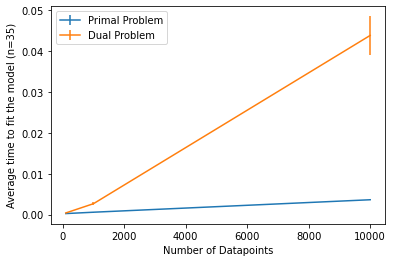

In [20]:
time2.plotting()

We can see that Primal Problem is faster in this seeting as expected.

## Features>Samples Setting

Number of features :  400\
Number of informative features :  20\
Number of clusters per class :  2\
Number of Montecarlo iterations :  100\
Samples: [100,200,300,500]

In [21]:
time2 = timeit(400, 20, 2, [100,200,300,500], 2, 1)
time2.run_all(100)
time2.print_Results()


############################################################################
Number of Samples :  100
Number of features :  400
Number of informative features :  20
Number of clusters per class :  2
Number of Montecarlo iterations :  100
####################--RESULTS--##############################
Problem (Primal/Dual):  Primal
Average time to fit the model 0.06020483732223511
Variance of time fit the model 0.016874605997753974
Average Accuracy achieved 1.0
############################################################################
############################################################################
Number of Samples :  100
Number of features :  400
Number of informative features :  20
Number of clusters per class :  2
Number of Montecarlo iterations :  100
####################--RESULTS--##############################
Problem (Primal/Dual):  Dual
Average time to fit the model 0.0018016600608825684
Variance of time fit the model 0.0004903892805955227
Average Accuracy achieved 

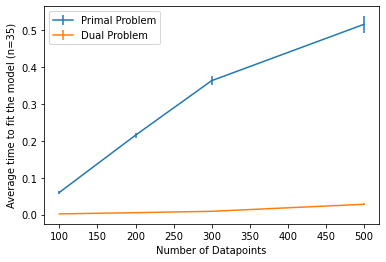

In [22]:
time2.plotting()

We see that in this setting the Dual problem is much faster.

# another comparison

In [23]:
time2 = timeit(3000, 20, 1, [100,500,1000,2000], 2, 1)
time2.run_all(100)
time2.print_Results()


############################################################################
Number of Samples :  100
Number of features :  3000
Number of informative features :  20
Number of clusters per class :  1
Number of Montecarlo iterations :  100
####################--RESULTS--##############################
Problem (Primal/Dual):  Primal
Average time to fit the model 0.15004245519638063
Variance of time fit the model 0.0306562114903919
Average Accuracy achieved 1.0
############################################################################
############################################################################
Number of Samples :  100
Number of features :  3000
Number of informative features :  20
Number of clusters per class :  1
Number of Montecarlo iterations :  100
####################--RESULTS--##############################
Problem (Primal/Dual):  Dual
Average time to fit the model 0.007426750659942627
Variance of time fit the model 0.0009610391046247753
Average Accuracy achieved 1

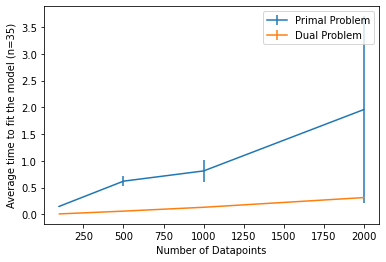

In [24]:
time2.plotting()

Dual problem faster again.

# simualtion to create plot like in the report.

In [ ]:
time2 = timeit(600, 20, 2, np.arange(50,4200,50), 2, 1)
time2.run_all(35)

In [ ]:
time2.plotting()